In [104]:
from graph_traffic.dataloading import graph_dataset, npzDataset
from graph_traffic.dcrnn import DiffConv
from graph_traffic.config import project_path
from graph_traffic.model import GraphRNN
from graph_traffic.train import train, eval, predict
from graph_traffic.utils import NormalizationLayer, masked_mae_loss
from graph_traffic.get_data import get_data, plot_graph

import matplotlib.pyplot as plt

from datetime import datetime
from torch.utils.data import DataLoader
import dgl
import torch
from functools import partial

## 0. Define training parameters

In [105]:
n_points = None
batch_size = 64
diffsteps = 2
decay_steps = 2000
lr = 0.01
minimum_lr = 2e-6
epochs = 100
max_grad_norm = 5.0
num_workers = 0
model = "dcrnn"
gpu = -1
num_heads = 2 # relevant for model="gaan"
out_feats = 4*256
num_layers = 2

In [106]:
if gpu == -1:
    device = torch.device('cpu')
else:
    device = torch.device('cuda:{}'.format(gpu))

## 1. Load data

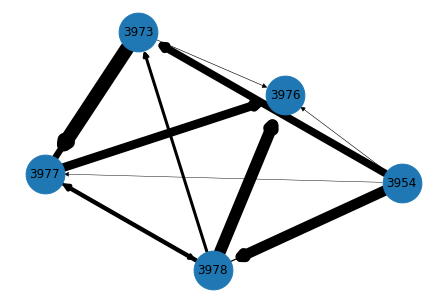

In [107]:
ids_list = [3954, 3973, 3976, 3977, 3978]
rain = "ordinal"
wind = "wind_speed"
season = "ordinal"
month = "spline"
day_of_month = "trigonometric"
hour = "spline"
interactions = None
seq_len = 12
with_graph = True
from_date = "2019-03-01"
to_date = "2019-03-31"
dataset_name = "small"

x, y, g = get_data(ids_list, seq_len, rain, wind, season, month, day_of_month, hour, interactions, with_graph, from_date, to_date, dataset_name)
plot_graph(g, ids_list, save=True)

In [108]:
g.edata

{'weight': tensor([0.2523, 0.0192, 0.0155, 0.3520, 0.0200, 0.4712, 0.2180, 0.2915, 0.1000,
        0.0416, 0.1000, 0.3932, 0.1465], dtype=torch.float64)}

In [109]:
g = graph_dataset(dataset_name)
train_data = npzDataset(dataset_name, "train", n_points)
test_data = npzDataset(dataset_name, "test", n_points)
valid_data = npzDataset(dataset_name, "valid", n_points)

seq_len = train_data.x.shape[1]
in_feats = train_data.x.shape[-1]

In [110]:
train_data.x.shape, train_data.y.shape

((53, 4, 5, 36), (53, 4, 5, 36))

In [111]:
valid_data.x.shape, valid_data.y.shape

((18, 4, 5, 36), (18, 4, 5, 36))

In [112]:
test_data.x.shape, test_data.y.shape

((18, 4, 5, 36), (18, 4, 5, 36))

In [113]:
train_loader = DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(
    valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

normalizer = NormalizationLayer(train_data.min, train_data.max)

## 2. Define the model

In [114]:
if model == "dcrnn":
    batch_g = dgl.batch([g] * batch_size).to(device)
    out_gs, in_gs = DiffConv.attach_graph(batch_g, diffsteps)
    net = partial(DiffConv, k=diffsteps, in_graph_list=in_gs, out_graph_list=out_gs)
elif model == 'gaan':
    print("not available")

dcrnn = GraphRNN(in_feats=in_feats,
                 out_feats=out_feats,
                 seq_len=seq_len,
                 num_layers=num_layers,
                 net=net,
                 decay_steps=decay_steps).to(device)

## 3. Define learning parameters

In [115]:
optimizer = torch.optim.Adam(dcrnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

loss_fn = masked_mae_loss

## 4. Train model

Después de hacer el cambio sigmoid -> tanh

In [116]:
train_losses = []
valid_losses = []
test_losses = []
for e in range(epochs):
    train(dcrnn, g, train_loader, optimizer, scheduler, normalizer, loss_fn, device, batch_size, max_grad_norm, minimum_lr)
    train_loss = eval(dcrnn, g, train_loader, normalizer, loss_fn, device, batch_size)
    valid_loss = eval(dcrnn, g, valid_loader, normalizer, loss_fn, device, batch_size)
    test_loss = eval(dcrnn, g, test_loader, normalizer, loss_fn, device, batch_size)
    print(f"Epoch: {e} Train Loss: {train_loss} Valid Loss: {valid_loss} Test Loss: {test_loss}")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_losses.append(test_loss)

C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 0 Train Loss: 4531.4365234375 Valid Loss: 4408.45458984375 Test Loss: 4435.03955078125
Epoch: 1 Train Loss: 3516.78271484375 Valid Loss: 3266.799560546875 Test Loss: 3457.072998046875
Epoch: 2 Train Loss: 2032.466552734375 Valid Loss: 1829.817626953125 Test Loss: 1902.247314453125
Epoch: 3 Train Loss: 608.8314208984375 Valid Loss: 391.06134033203125 Test Loss: 600.5753173828125
Epoch: 4 Train Loss: 881.4098510742188 Valid Loss: 1083.84228515625 Test Loss: 1031.692626953125
Epoch: 5 Train Loss: 1189.0355224609375 Valid Loss: 1303.0472412109375 Test Loss: 1249.966796875
Epoch: 6 Train Loss: 874.9666137695312 Valid Loss: 1126.1187744140625 Test Loss: 778.9329223632812
Epoch: 7 Train Loss: 327.74444580078125 Valid Loss: 504.82257080078125 Test Loss: 428.88970947265625
Epoch: 8 Train Loss: 340.2158203125 Valid Loss: 133.74237060546875 Test Loss: 190.62893676757812
Epoch: 9 Train Loss: 411.15081787109375 Valid Loss: 179.22021484375 Test Loss: 309.3744812011719
Epoch: 10 Train Loss: 36

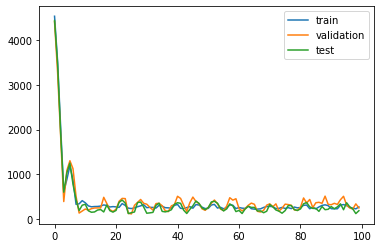

In [125]:
fig, ax = plt.subplots()
#ax.set_title(f"de {(y[:, i, 1]*24).min().numpy()} a  {(y[:, i, 1]*24).max().numpy()}, sensor{i%5+1}")
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="validation")
ax.plot(test_losses, label="test")
plt.legend()
plt.show()

## 5. Save model

In [118]:
torch.save(dcrnn.state_dict(), f"{project_path}/models/dcrnn.pt")

## 6. Try model

In [119]:
y[:, 2, 0]

array([[ 75.   ,  13.95 ,  37.5  , ...,   0.   ,   1.   ,   1.   ],
       [ 96.   ,  13.725,  37.75 , ...,   0.   ,   1.   ,   1.   ],
       [ 80.   ,  13.5  ,  38.   , ...,   0.   ,   1.   ,   1.   ],
       ...,
       [401.   ,  14.9  ,  38.   , ...,   0.   ,   1.   ,   1.   ],
       [301.   ,  14.675,  38.   , ...,   0.   ,   1.   ,   1.   ],
       [230.   ,  14.45 ,  38.   , ...,   0.   ,   1.   ,   1.   ]])

In [120]:
y_pred[:, 3, 0]

tensor([-63.7908, -74.0325, -69.6869, -74.0274], grad_fn=<SelectBackward0>)

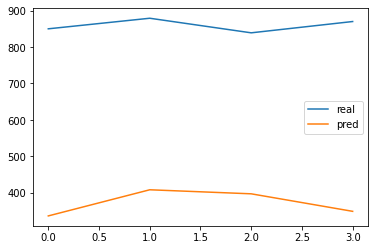

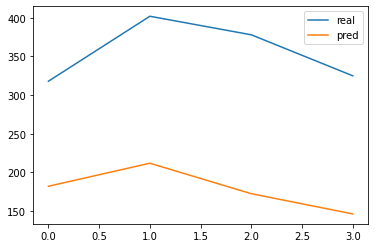

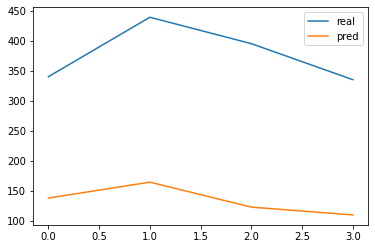

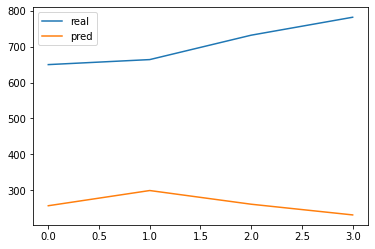

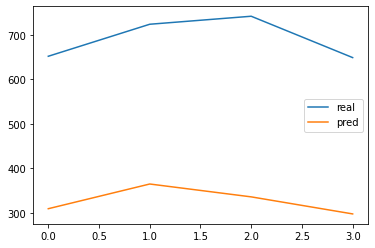

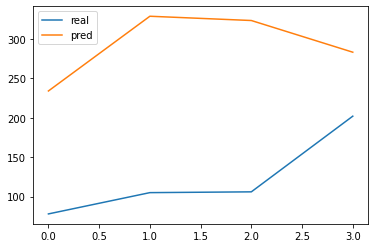

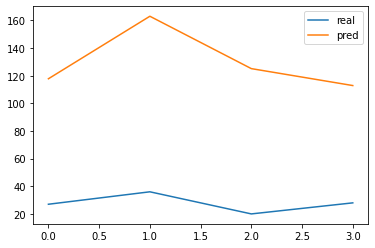

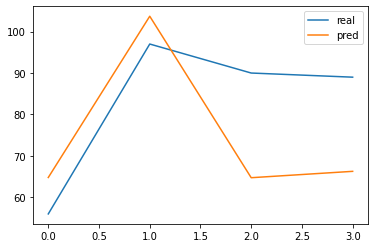

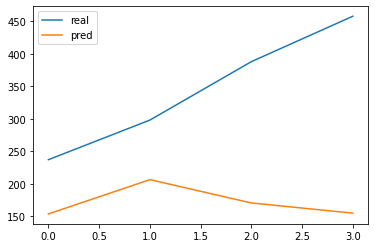

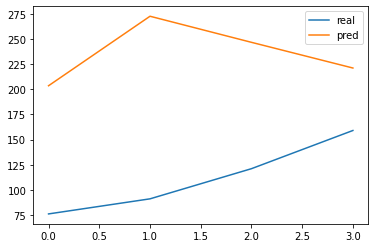

In [121]:
for i, (x, y) in enumerate(train_loader):
    #x, y, x_norm, y_norm, batch_graph = prepare_data(g.to(device), x, y, normalizer, args.batch_size, device)
    #y_pred = predict(dcrnn, batch_graph, x_norm, y_norm, normalizer, device, i)
    dcrnn.eval()
    y, y_pred = predict(x, y, batch_size, g.to(device), dcrnn, device, normalizer)
    break

for i in range(10):
    fig, ax = plt.subplots()
    #ax.set_title(f"de {(y[:, i, 1]*24).min().numpy()} a  {(y[:, i, 1]*24).max().numpy()}, sensor{i%5+1}")
    ax.plot(y[:, i, 0].detach().numpy(), label="real")
    ax.plot(y_pred[:, i, 0].detach().numpy(), label="pred")
    plt.legend()

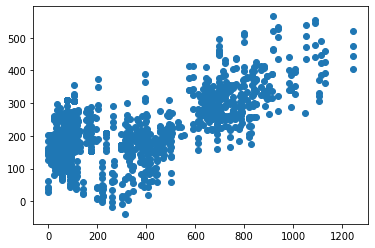

In [122]:
plt.scatter(y.detach().numpy().ravel(), y_pred.detach().numpy().ravel())

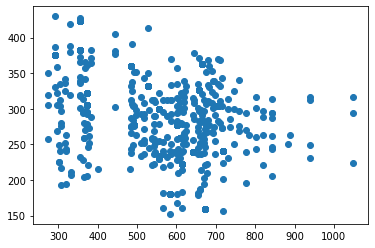

In [123]:
for i, (x, y) in enumerate(valid_loader):
    #x, y, x_norm, y_norm, batch_graph = prepare_data(g.to(device), x, y, normalizer, args.batch_size, device)
    #y_pred = predict(dcrnn, batch_graph, x_norm, y_norm, normalizer, device, i)
    dcrnn.eval()
    y, y_pred = predict(x, y, batch_size, g.to(device), dcrnn, device, normalizer)
    break
plt.scatter(y.detach().numpy().ravel(), y_pred.detach().numpy().ravel())

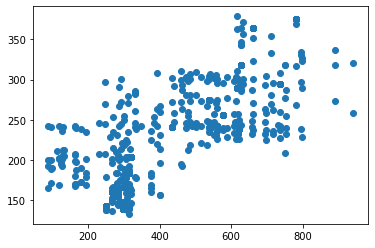

In [124]:
for i, (x, y) in enumerate(test_loader):
    #x, y, x_norm, y_norm, batch_graph = prepare_data(g.to(device), x, y, normalizer, args.batch_size, device)
    #y_pred = predict(dcrnn, batch_graph, x_norm, y_norm, normalizer, device, i)
    dcrnn.eval()
    y, y_pred = predict(x, y, batch_size, g.to(device), dcrnn, device, normalizer)
    break
plt.scatter(y.detach().numpy().ravel(), y_pred.detach().numpy().ravel())